In [1]:
# 📚 Libraries 
import kagglehub
import pandas as pd
import numpy as np
import os

# New liabraries. 
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 📊 Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as g

# 🤖 Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 

In [2]:
# Download latest version
#path = kagglehub.dataset_download("andrewmvd/sp-500-stocks")


In [ ]:
# Print all files in the dataset path
#print(os.listdir(path))

In [4]:
#csv_file_path = os.path.join(path, 'sp500_stocks.csv')
#csv_file_path2 = os.path.join(path, 'sp500_companies.csv')
#csv_file_path3 = os.path.join(path, 'sp500_index.csv')
#data = pd.read_csv(csv_file_path)
#df = pd.read_csv(csv_file_path2)
#sp = pd.read_csv(csv_file_path3)

In [2]:
data = pd.read_csv('sp500_stocks.csv')
df = pd.read_csv('sp500_companies.csv')
sp = pd.read_csv('sp500_index.csv')

In [3]:
data.columns = [col.lower().replace(" ", "_")for col in data.columns] #snake_case
df.columns = [col.lower().replace(" ", "_")for col in df.columns] #snake_case
sp.columns = [col.lower().replace(" ", "_")for col in sp.columns] #snake_case

In [4]:
# Copies 
data2 = data.copy()
df2 = df.copy()
sp2 = sp.copy()

In [5]:
data2.dtypes

date          object
symbol        object
adj_close    float64
close        float64
high         float64
low          float64
open         float64
volume       float64
dtype: object

In [6]:
data.isna().sum()

date              0
symbol            0
adj_close    101626
close        101626
high         101626
low          101626
open         101626
volume       101626
dtype: int64

In [7]:
# Delete Columns 
data2.drop(columns=['high', 'low', 'open','close'], inplace=True)

In [8]:
data2.isna().sum()

date              0
symbol            0
adj_close    101626
volume       101626
dtype: int64

In [9]:
# Delete NaN. TELL WHY I'M dropping 
data2.dropna(how='any', inplace=True)

In [10]:
data2.isna().sum()

date         0
symbol       0
adj_close    0
volume       0
dtype: int64

In [11]:
# Change to datetime. 
data2['date'] = pd.to_datetime(data2['date'])

In [12]:
data2['year'] = data2['date'].dt.year
data2['month'] = data2['date'].dt.month
data2['day'] = data2['date'].dt.day

In [13]:
cols = ['year', 'month', 'day', 'symbol', 'adj_close', 'volume']
data2 = data2[cols]
data2.head(3)

,year,month,day,symbol,adj_close,volume
0,2010,1,4,MMM,43.783867,3640265.0
1,2010,1,5,MMM,43.509628,3405012.0
2,2010,1,6,MMM,44.126682,6301126.0


In [14]:
# Drop rows where year is between 2010 and 2013 because SP500 for comparison we do have 2014. 
data2.drop(data2[(data2['year'] >= 2010) & (data2['year'] <= 2014)].index, inplace=True)

In [15]:
# Chat helped. 
annual_returns = data2.groupby(['symbol', 'year']).apply(lambda group: (group['adj_close'].iloc[-1] / group['adj_close'].iloc[0]) - 1).reset_index(name='annual_return').round(4)

/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_9762/292607746.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_returns = data2.groupby(['symbol', 'year']).apply(lambda group: (group['adj_close'].iloc[-1] / group['adj_close'].iloc[0]) - 1).reset_index(name='annual_return').round(4)


In [16]:
pivoted_df = annual_returns.pivot(index='symbol', columns='year', values='annual_return')
pivoted_df.sample(3)

year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
symbol,,,,,,,,,,
STT,-0.1371,0.2206,0.2537,-0.3336,0.2761,-0.0672,0.3200,-0.1508,0.0244,0.3004
WBD,-0.2262,0.0379,-0.1996,0.0705,0.2675,-0.0661,-0.2315,-0.6257,0.1929,-0.0858
BWA,-0.2022,-0.0517,0.2918,-0.3189,0.2572,-0.1037,0.2019,-0.0940,0.0245,-0.0471


In [17]:
pivoted_df = pivoted_df.rename(columns={2015: 'ar_2015',2016:'ar_2016',2017: 'ar_2017', 
                                          2018:'ar_2018', 2019: 'ar_2019',2020: 'ar_2020', 2021: 'ar_2021', 2022:'ar_2022', 2023:'ar_2023',2024: 'ar_2024'})

In [18]:
defi = pd.merge (df, pivoted_df, on='symbol')
defi

,exchange,symbol,shortname,longname,sector,industry,currentprice,marketcap,ebitda,revenuegrowth,...,ar_2015,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,242.84,3670720643072,1.346610e+11,0.061,...,-0.0208,0.1238,0.4804,-0.0705,0.8874,0.7824,0.3806,-0.2820,0.5480,0.3145
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,142.44,3488355713024,6.118400e+10,1.224,...,0.6645,2.3292,0.9043,-0.3285,0.7341,1.1802,1.2448,-0.5144,2.4610,1.9580
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,443.57,3297889746944,1.365520e+11,0.160,...,0.2188,0.1651,0.3974,0.2022,0.5826,0.3994,0.5579,-0.2769,0.5835,0.2050
3,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,227.03,2387220627456,1.115830e+11,0.110,...,1.1907,0.1772,0.5517,0.2632,0.2006,0.7160,0.0464,-0.5071,0.7704,0.5142
4,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,176.49,2149065949184,1.234700e+11,0.151,...,0.4500,0.0404,0.3311,-0.0276,0.2784,0.2812,0.6743,-0.3884,0.5711,0.2646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,NYQ,BWA,BorgWarner Inc.,BorgWarner Inc.,Consumer Cyclical,Auto Parts,33.80,7392059904,1.882000e+09,-0.048,...,-0.2022,-0.0517,0.2918,-0.3189,0.2572,-0.1037,0.2019,-0.0940,0.0245,-0.0471
499,NYQ,HII,"Huntington Ingalls Industries,","Huntington Ingalls Industries, Inc.",Industrials,Aerospace & Defense,187.95,7354351616,1.071000e+09,-0.024,...,0.1491,0.5029,0.2615,-0.1545,0.3244,-0.3181,0.1651,0.2680,0.1633,-0.2620
500,NYQ,FMC,FMC Corporation,FMC Corporation,Basic Materials,Agricultural Inputs,56.58,7063221248,7.033000e+08,0.085,...,-0.3028,0.5106,0.6741,-0.2186,0.5627,0.1725,-0.0103,0.1542,-0.4807,-0.1023
501,NMS,QRVO,"Qorvo, Inc.","Qorvo, Inc.",Technology,Semiconductors,68.33,6459010048,6.731300e+08,-0.052,...,-0.2770,0.0396,0.2590,-0.1183,0.8998,0.4339,-0.0498,-0.4315,0.2633,-0.3726


In [20]:
#Dropping Columns: Exchange, longname, longbusinesssumary. 
cols = ['symbol', 'shortname','sector','industry',
        'marketcap','ebitda', 'revenuegrowth', 'city', 'state', 'country',   
        'fulltimeemployees', 'weight', 'ar_2015', 'ar_2016', 'ar_2017', 'ar_2018', 'ar_2019',
        'ar_2020', 'ar_2021', 'ar_2022', 'ar_2023', 'ar_2024', 'currentprice']

In [34]:
definitive = defi[cols]

In [35]:
cat = defi.select_dtypes(exclude='number')
cat.head(5)

,symbol,shortname,sector,industry,city,state,country
0,AAPL,Apple Inc.,Technology,Consumer Electronics,Cupertino,CA,United States
1,NVDA,NVIDIA Corporation,Technology,Semiconductors,Santa Clara,CA,United States
2,MSFT,Microsoft Corporation,Technology,Software - Infrastructure,Redmond,WA,United States
3,AMZN,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,Seattle,WA,United States
4,GOOG,Alphabet Inc.,Communication Services,Internet Content & Information,Mountain View,CA,United States


In [36]:
num = defi.select_dtypes(include='number')
num.head(5)

,marketcap,ebitda,revenuegrowth,fulltimeemployees,weight,ar_2015,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024,currentprice
0,3670720643072,1.346610e+11,0.061,164000.0,0.064589,-0.0208,0.1238,0.4804,-0.0705,0.8874,0.7824,0.3806,-0.2820,0.5480,0.3145,242.84
1,3488355713024,6.118400e+10,1.224,29600.0,0.061381,0.6645,2.3292,0.9043,-0.3285,0.7341,1.1802,1.2448,-0.5144,2.4610,1.9580,142.44
2,3297889746944,1.365520e+11,0.160,228000.0,0.058029,0.2188,0.1651,0.3974,0.2022,0.5826,0.3994,0.5579,-0.2769,0.5835,0.2050,443.57
3,2387220627456,1.115830e+11,0.110,1551000.0,0.042005,1.1907,0.1772,0.5517,0.2632,0.2006,0.7160,0.0464,-0.5071,0.7704,0.5142,227.03
4,2149065949184,1.234700e+11,0.151,181269.0,0.037815,0.4500,0.0404,0.3311,-0.0276,0.2784,0.2812,0.6743,-0.3884,0.5711,0.2646,176.49


In [38]:
definitive.describe()

,marketcap,ebitda,revenuegrowth,fulltimeemployees,weight,ar_2015,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024,currentprice
count,5.030000e+02,4.740000e+02,500.000000,4.940000e+02,503.000000,475.000000,480.000000,482.000000,485.000000,491.000000,495.000000,495.000000,497.000000,499.000000,503.000000,503.000000
mean,1.129853e+11,7.031397e+09,0.070484,5.774496e+04,0.001988,0.045306,0.197734,0.258852,-0.034976,0.352786,0.192008,0.328778,-0.085353,0.195019,0.215239,230.293300
std,3.399129e+11,1.622777e+10,0.180071,1.394693e+05,0.005981,0.253423,0.277769,0.260448,0.225112,0.317066,0.548745,0.295113,0.279833,0.356690,0.382605,521.997583
min,5.637307e+09,-3.991000e+09,-0.602000,2.800000e+01,0.000099,-0.753000,-0.710600,-0.430800,-0.576200,-0.543300,-0.580300,-0.350500,-0.710700,-0.480700,-0.652500,8.560000
25%,2.036663e+10,1.623194e+09,0.002000,1.020000e+04,0.000358,-0.107050,0.047800,0.094325,-0.192900,0.185550,-0.051000,0.131250,-0.266900,-0.028700,0.004500,71.545000
50%,3.803281e+10,2.941705e+09,0.050000,2.159500e+04,0.000669,0.040700,0.177950,0.223250,-0.037800,0.328700,0.123900,0.306900,-0.114600,0.127500,0.167400,126.820000
75%,8.419720e+10,6.017250e+09,0.109000,5.476225e+04,0.001482,0.177300,0.310375,0.386175,0.093100,0.478200,0.302250,0.472350,0.057700,0.324050,0.371450,239.190000
max,3.670721e+12,1.495470e+11,1.632000,2.100000e+06,0.064589,1.722800,3.093900,1.427200,1.065900,4.311000,7.200500,1.900200,1.071300,2.461000,3.604300,8946.330000


In [39]:
frequency_table = cat.sector.value_counts()
proportion_table = cat.sector.value_counts(normalize=True)

In [40]:
frequency_proportion = pd.concat([frequency_table,proportion_table], axis = 1)
frequency_proportion.columns = ['absolute_frequency', 'relative_frequency']
frequency_proportion

,absolute_frequency,relative_frequency
sector,,
Technology,82,0.163022
Industrials,70,0.139165
Financial Services,67,0.133201
Healthcare,63,0.125249
Consumer Cyclical,55,0.109344
Consumer Defensive,37,0.073559
Utilities,32,0.063618
Real Estate,31,0.061630
Communication Services,22,0.043738


In [41]:
total_absolute = frequency_table.sum()
total_relative = proportion_table.sum()

In [42]:
total_row = pd.DataFrame({
    'absolute_frequency': [total_absolute],
    'relative_frequency': [total_relative]
}, index=['Total'])
total_row

,absolute_frequency,relative_frequency
Total,503,1.0


In [43]:
df3 = pd.concat([frequency_proportion, total_row])

In [44]:
df3

,absolute_frequency,relative_frequency
Technology,82,0.163022
Industrials,70,0.139165
Financial Services,67,0.133201
Healthcare,63,0.125249
Consumer Cyclical,55,0.109344
Consumer Defensive,37,0.073559
Utilities,32,0.063618
Real Estate,31,0.061630
Communication Services,22,0.043738
Energy,22,0.043738


The frequency table gives the count of each sector, while the proportion table provides the percentage representation of each category in the dataset. This helps to quickly identify dominant and minority categories. Such as:
- Technology: 16% 
- Industrials: 14% 
- Financial Services: 13% 
- Healthcare: 12% 
- Consumer Cyclical: 10% 

In [45]:
tech = definitive[definitive['sector'] == 'Technology']
indus = definitive[definitive['sector'] == 'Industrials']
fin = definitive[definitive['sector'] == 'Financial Services']
health = definitive[definitive['sector'] == 'Healthcare']
consumer = definitive[definitive['sector'] == 'Consumer Cyclical']

In [51]:
df3.columns

Index(['absolute_frequency', 'relative_frequency'], dtype='object')

/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_9762/3055570902.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


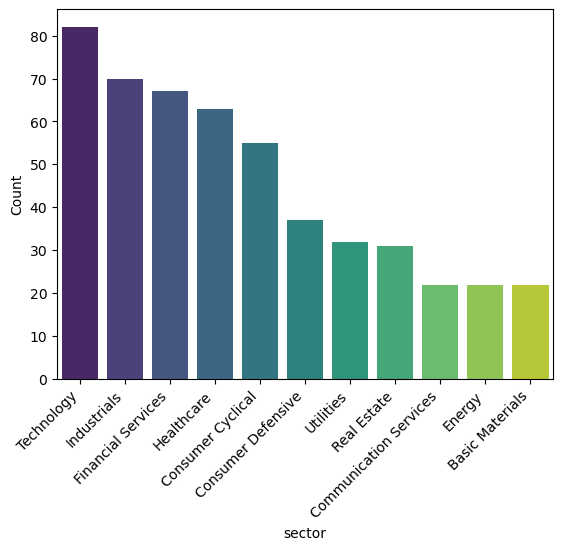

In [57]:
sns.barplot(
    x='sector',
    y='absolute_frequency',
    data=frequency_proportion,
    palette='viridis',
)
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

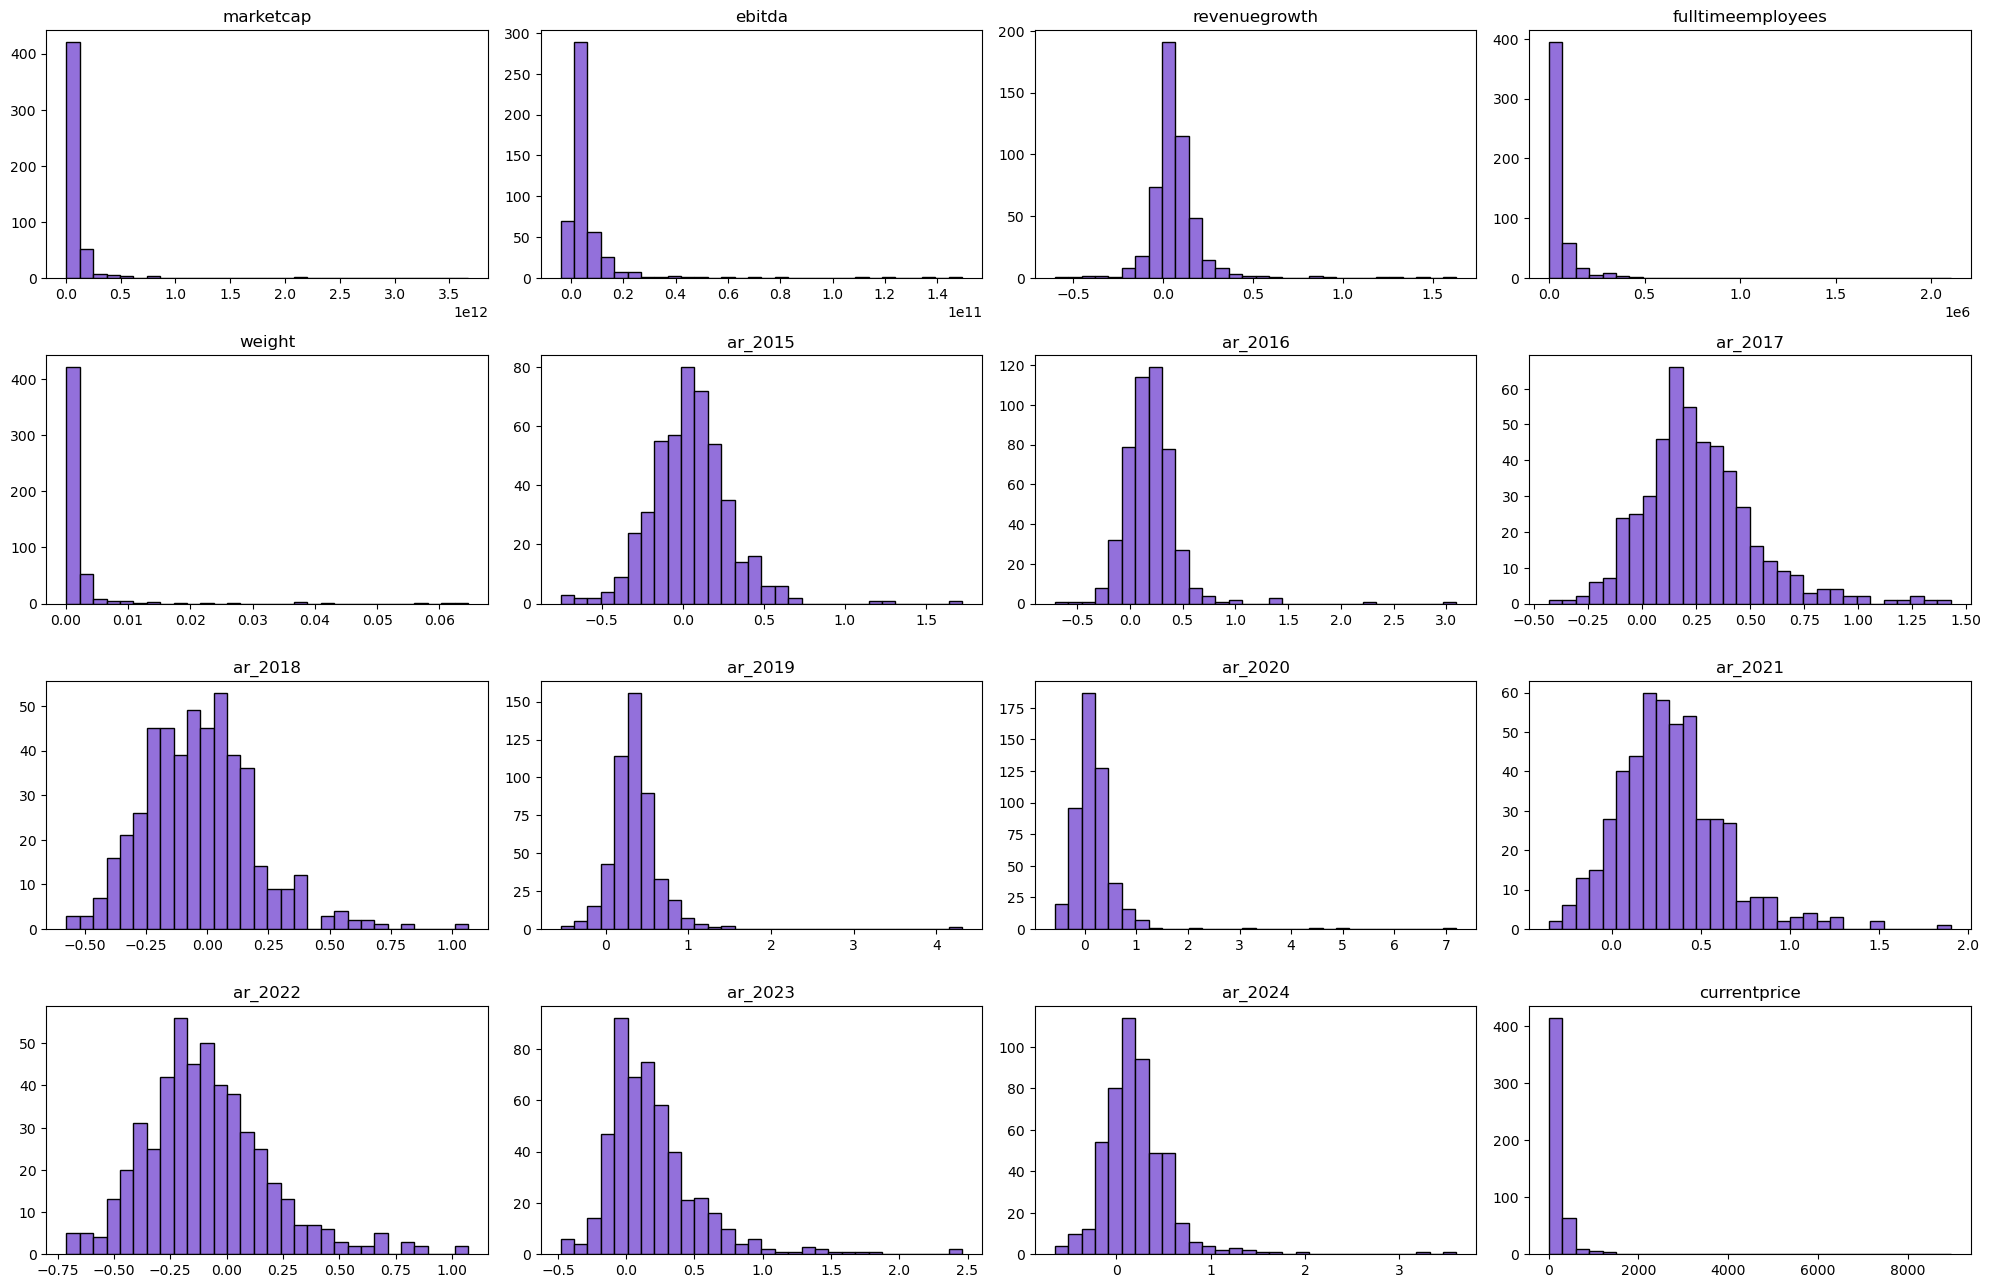

In [58]:
color = '#9370DB'

nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)  # hide unesed plots
        continue
    ax.hist(num.iloc[:, i], bins=30, color=color, edgecolor='black')
    ax.set_title(num.columns[i])

plt.tight_layout()
plt.show()

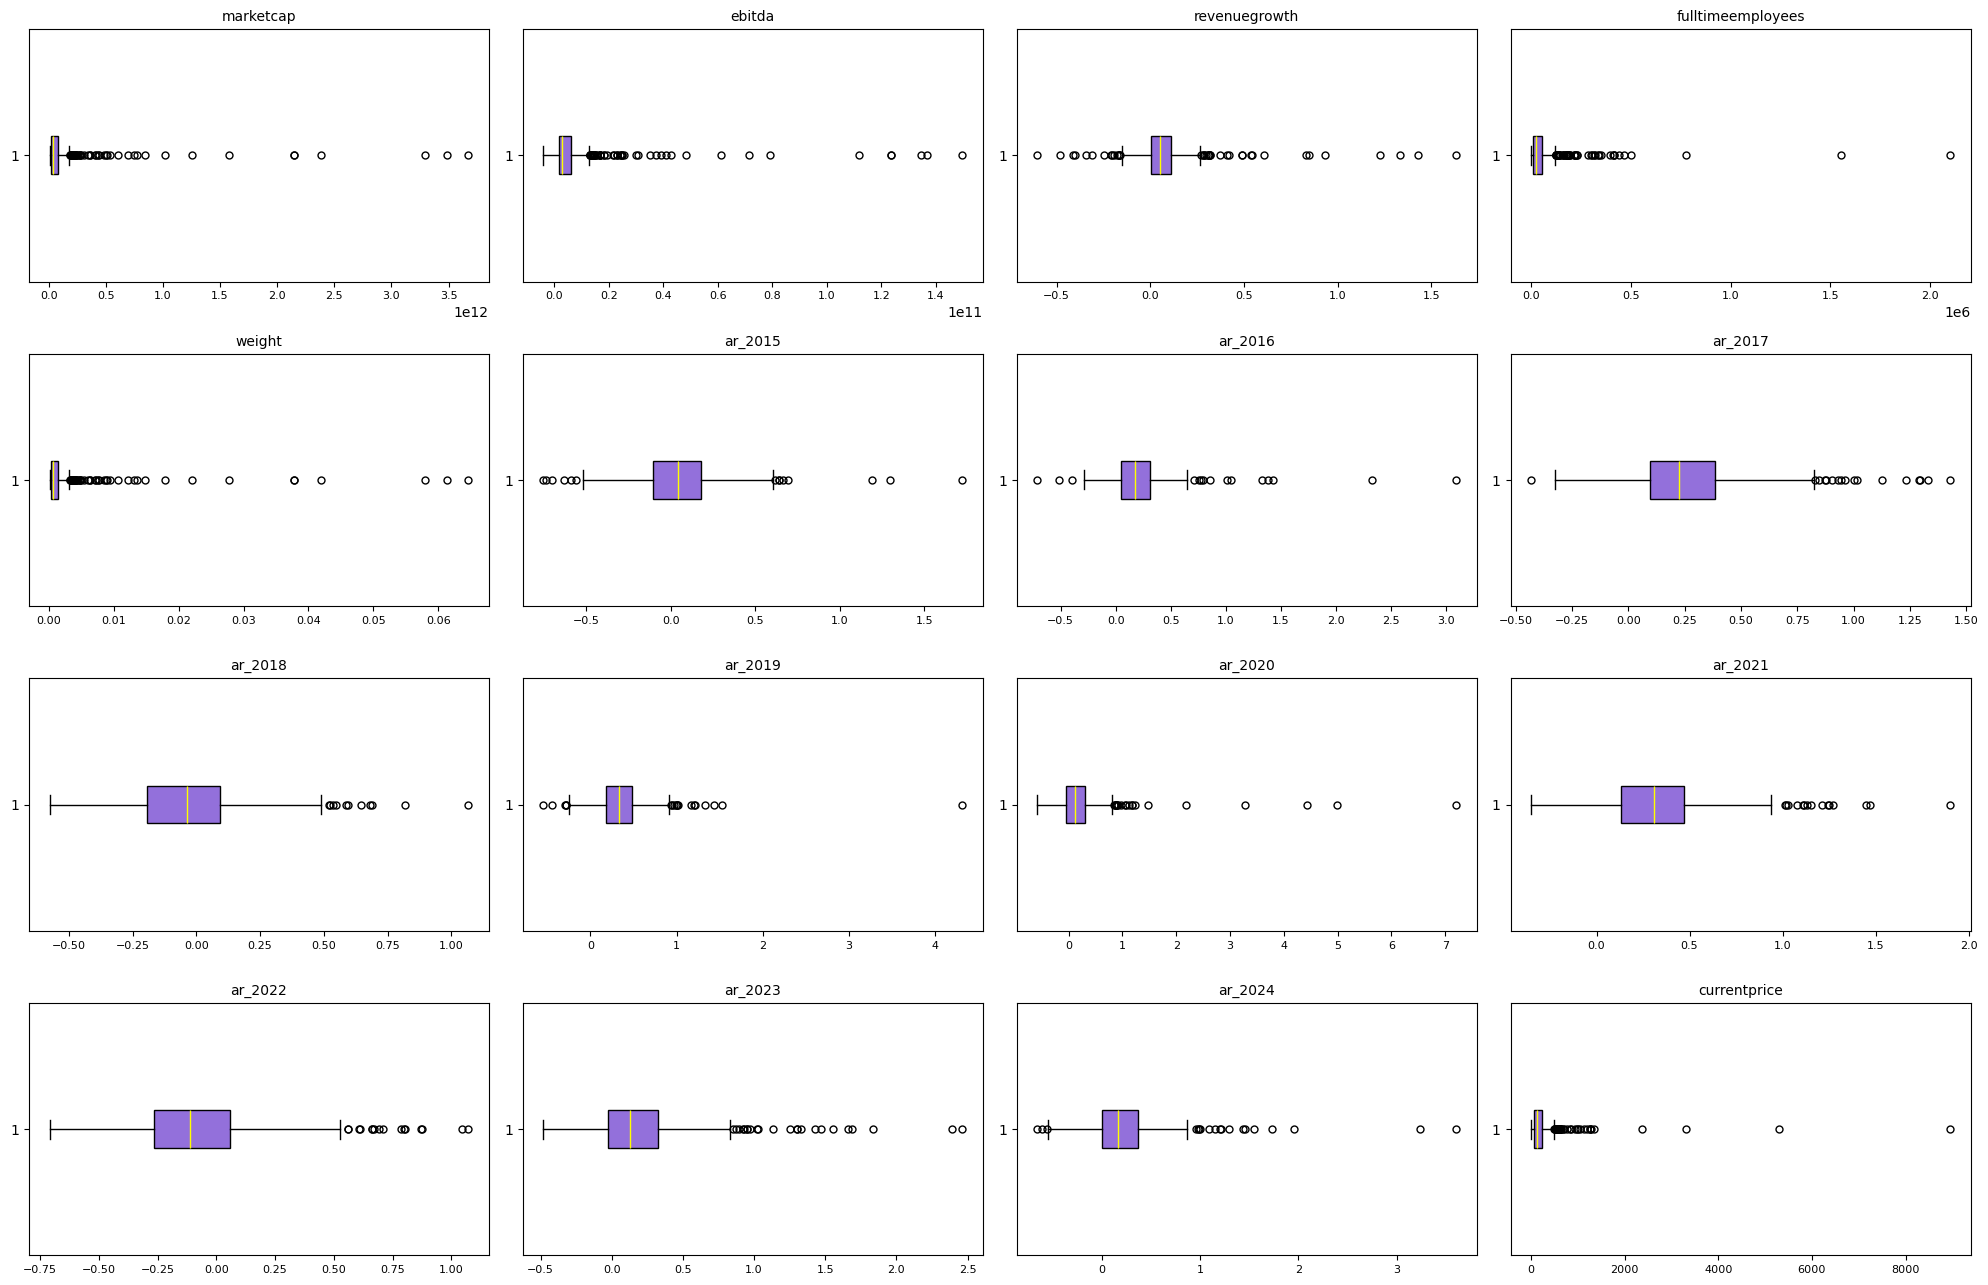

In [59]:
color = '#9370DB'

# grid size
nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)
        continue
    ax.boxplot(num.iloc[:, i].dropna(), vert=False, patch_artist=True, 
               boxprops=dict(facecolor=color, color='black'), 
               medianprops=dict(color='yellow'), whiskerprops=dict(color='black'), 
               capprops=dict(color='black'), flierprops=dict(marker='o', color='red', markersize=5))
    ax.set_title(num.columns[i], fontsize=10)
    ax.tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

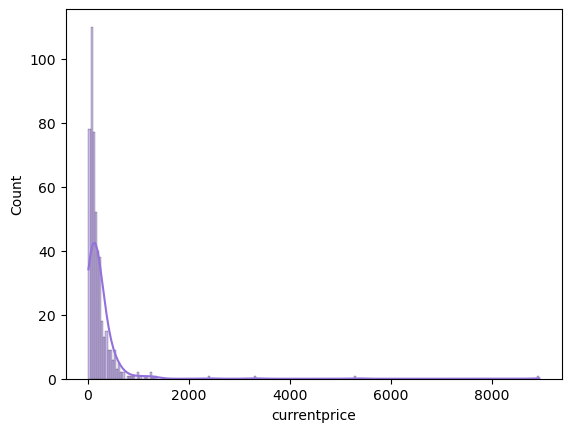

In [67]:
# Without the filter and having the outliers. 
sns.histplot(definitive["currentprice"], color=color, kde=True);

(0.0, 2100.0)

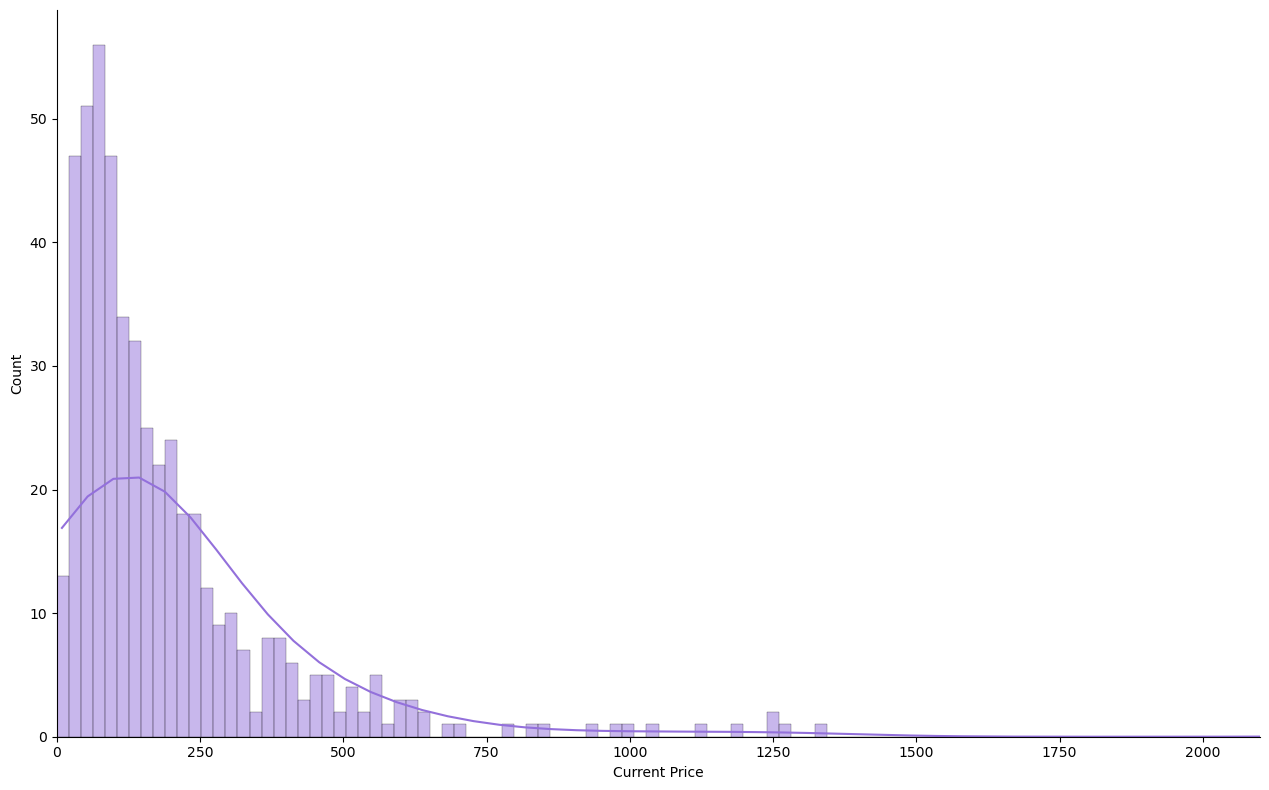

In [69]:
d2 = sns.displot(data=definitive, x='currentprice', kde=True, height=8, aspect=1.6, bins=100, binrange=(0, 2100), color='mediumpurple')
d2.set(xlabel='Current Price')
plt.xlim(0, 2100)

<Figure size 1500x1200 with 0 Axes>

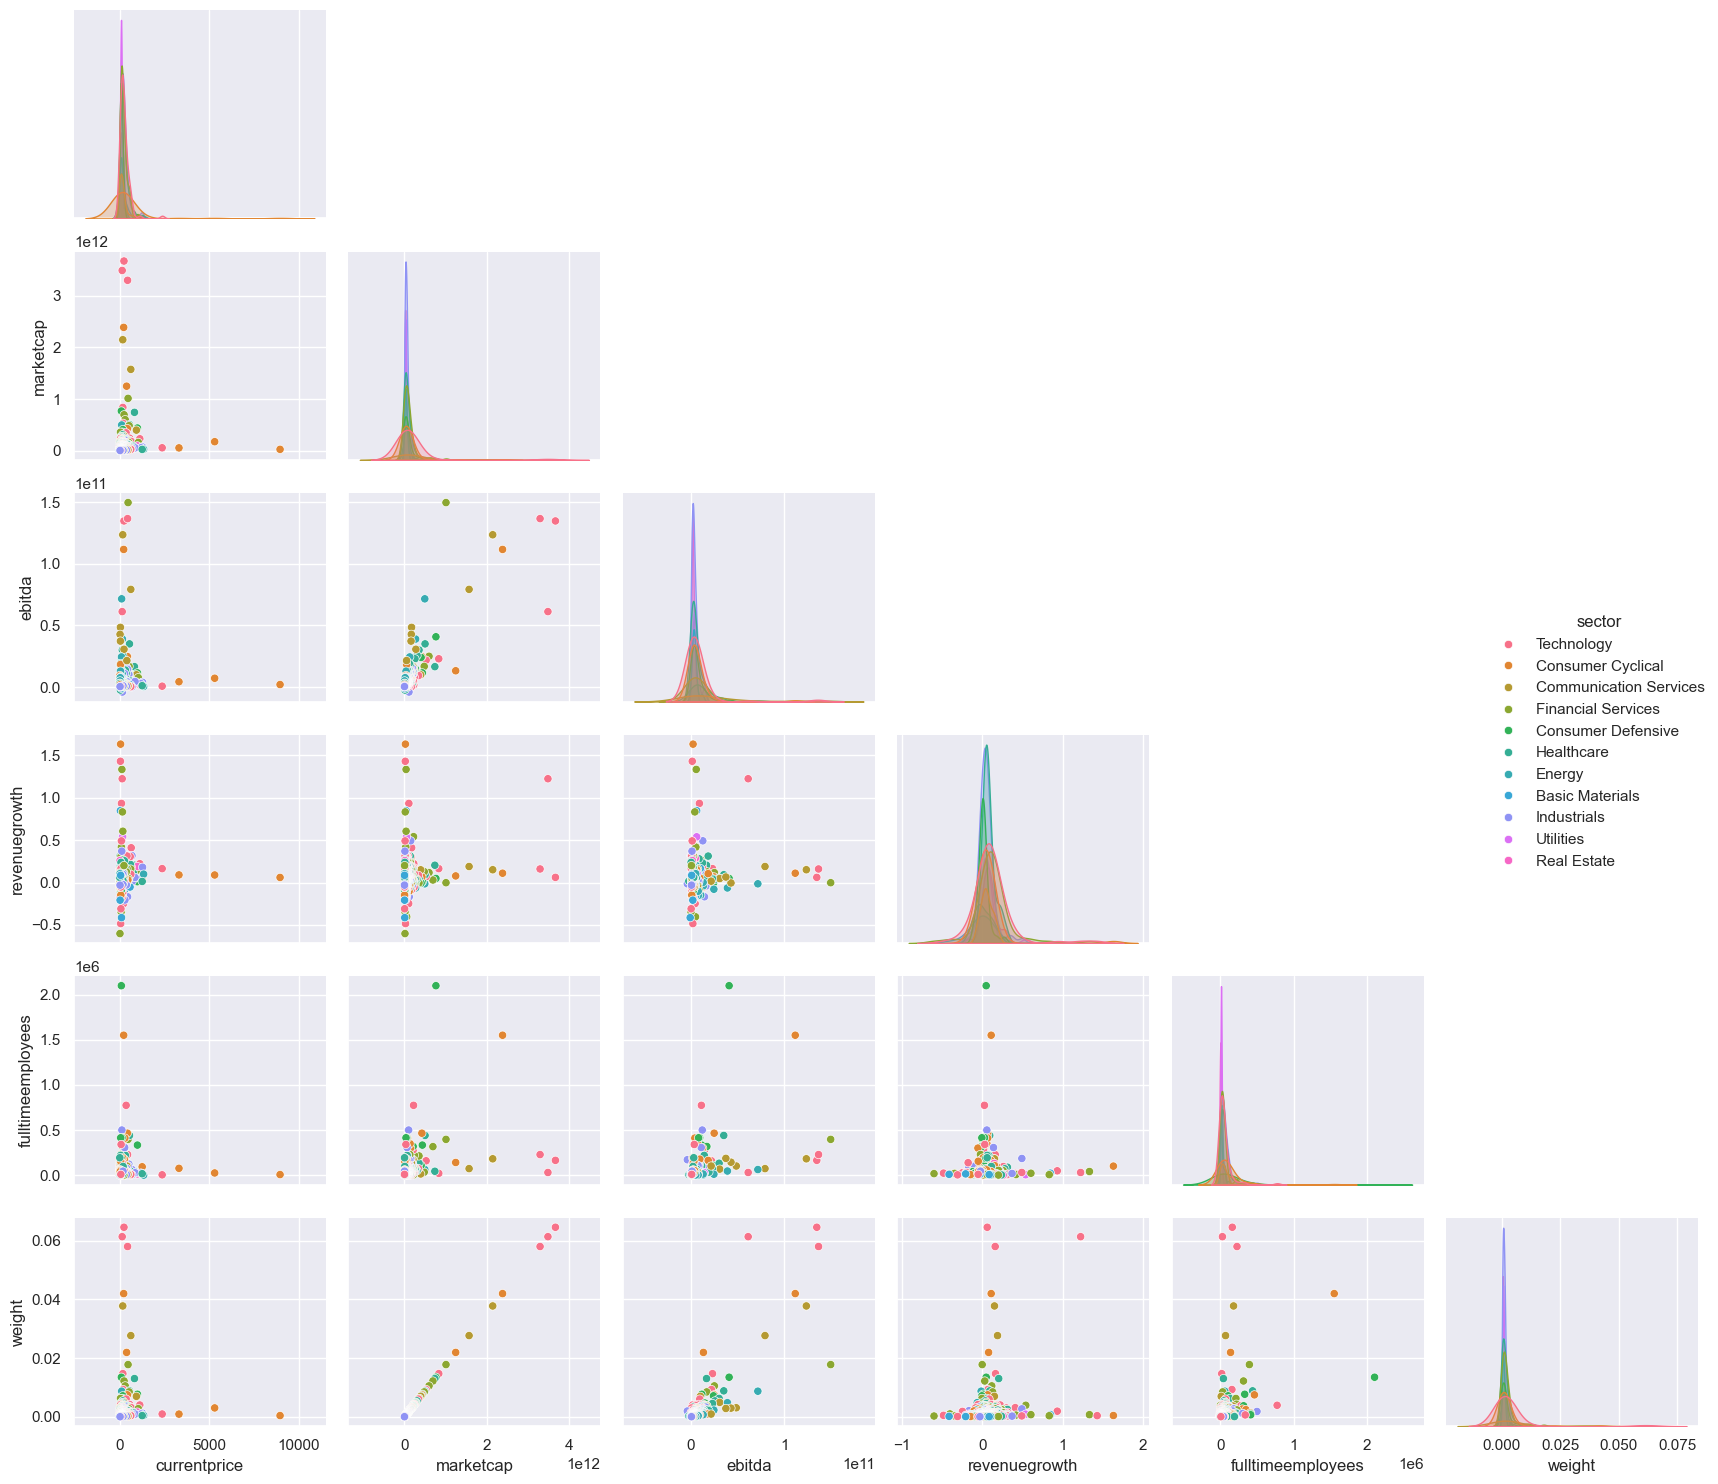

In [ ]:
# Check for this plot. 
sns.set(style='darkgrid')
plt.figure(figsize=(15,12))
sns.pairplot(df, corner=True, hue='sector')
plt.tight_layout()

In [ ]:
#Pearson 
num.corrwith(defi['currentprice'])

In [ ]:
#Spearman
num.corrwith(defi['currentprice'], method='spearman').sort_values(ascending=False)[:5]

In [ ]:
num_corr = num.corr()
num_corr

In [ ]:
# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True 
f, ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale=1.5)

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="BuPu", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation Heatmap", fontsize=20) 

In [ ]:
# Plotting scatter plots for each numerical column against 'currentprice' to visualize their relationships
for col in num.columns:
    plt.figure(figsize=(5, 5))
    plt.title('Scatter plot of price vs ' + col)
    sns.scatterplot(data=defi, x=col, y='currentprice')
    plt.show()

In [37]:
def outlier_slayer(data): 
    """
    Automatically removes outliers based on Q1, Q3
    """
    for column in data.select_dtypes(include=[np.number]):
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

In [38]:
definitive = outlier_slayer(defi)

In [ ]:
cat = definitive.select_dtypes(exclude='number')
cat.head(5)

In [ ]:
num = definitive.select_dtypes(include='number')
num.head(5)

In [ ]:
color = '#9370DB'

nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)  # hide unesed plots
        continue
    ax.hist(num.iloc[:, i], bins=30, color=color, edgecolor='black')
    ax.set_title(num.columns[i])

plt.tight_layout()
plt.show()

In [ ]:
# Dealing with outliers. 
sns.histplot(definitive["currentprice"], color=color, kde=True);

In [ ]:
# Without dealing with outliers. 
sns.histplot(defi["currentprice"], color=color, kde=True);

In [ ]:
# Without dealing with outliers. REVENUE
sns.histplot(defi["revenuegrowth"], color=color, kde=True);

In [ ]:
# Dealing with outliers. REVENUE
sns.histplot(definitive["revenuegrowth"], color=color, kde=True);

In [ ]:
#pearson 
num.corrwith(definitive['currentprice']).sort_values(ascending=False)

In [ ]:
#Spearman
num.corrwith(df['currentprice'], method='spearman').sort_values(ascending=False)[:5]

In [ ]:
#pearson 
num.corrwith(definitive['revenuegrowth']).sort_values(ascending=False)

In [ ]:
#Spearman
num.corrwith(df['revenuegrowth'], method='spearman').sort_values(ascending=False)[:5]

In [ ]:
color = '#9370DB'

# grid size
nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)
        continue
    ax.boxplot(num.iloc[:, i].dropna(), vert=False, patch_artist=True, 
               boxprops=dict(facecolor=color, color='black'), 
               medianprops=dict(color='yellow'), whiskerprops=dict(color='black'), 
               capprops=dict(color='black'), flierprops=dict(marker='o', color='red', markersize=5))
    ax.set_title(num.columns[i], fontsize=10)
    ax.tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

In [ ]:
num_corr = num.corr()
num_corr

In [ ]:
# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True 
f, ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale=1.5)

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="BuPu", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation Heatmap", fontsize=20) 

In [ ]:
# Plotting scatter plots for each numerical column against 'currentprice' to visualize their relationships
for col in num.columns:
    plt.figure(figsize=(5, 5))
    plt.title('Scatter plot of price vs ' + col)
    sns.scatterplot(data=definitive, x=col, y='currentprice')
    plt.show()

In [ ]:
defi

In [ ]:
# crosstab MSZoning and SaleCondition
crosstab_result = pd.crosstab(df['MSZoning'], df['SaleCondition'])
crosstab_result 

### T-Test: Two Tails (We could do it with the price of the stock or the revenue growth or ebitda)
We will conduct hypothesis testing to check if the **average price of 1st class tickets** on the Titanic was $65. We will use a **t-test** since we don't know the population standard deviation.

#### Key Questions:
- Are first-class ticket prices consistent with historical assumptions of $65?
- What are the hypotheses, and how can we test them statistically?

In [ ]:
# Step 2: Choose Significance Level
alpha = 0.05  # 5% significance level
# Step 3: Collect Data
first_class = df[df['Pclass'] == 1]['Fare'].dropna()
n = len(first_class)
n
# Display data information
print(f"Sample Size (n): {n}")
first_class.describe() # I do not know how to perfom just fare values. 
# Step 4: Calculate Test Statistic
mean = first_class.mean()
s = first_class.std()
mu = 65

In [ ]:
t_stat, p_value = st.ttest_1samp(first_class, mu)
print(f"Test Statistic (t): {t_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print()
if p_value > alpha:
    print("Fail to Reject the Null Hypothesis: Not enough evidence to say the average price is different from $65.")
else:
    print("Reject the Null Hypothesis: There is evidence to say the average price is different from $65.")

In [ ]:
# Nice to display information. 
# Display data information
print(f"Sample Size (n): {n}")
first_class.describe() # I do not know how to perfom just fare values. 

In [ ]:
# ADD ANOVA 

We will use **one-way ANOVA** to determine if there is a statistically significant difference in **stock price** based on **sector**.

#### Define Hypotheses
- **Null Hypothesis (H₀)**: There is no difference in mean stock prices between sectors such as at **Technolgies**, **Industrials**, and **Finance** companies.
- **Alternative Hypothesis (H₁)**: At least one group mean is different.

In [ ]:
# Extract salaries for Data Scientists by company size
df_small = df[(df["job_title"] == "Data Scientist") & (df["company_size"] == "Small")]["salary_in_usd"]
df_medium = df[(df["job_title"] == "Data Scientist") & (df["company_size"] == "Medium")]["salary_in_usd"]
df_large = df[(df["job_title"] == "Data Scientist") & (df["company_size"] == "Large")]["salary_in_usd"]

In [ ]:
# Perform One-Way ANOVA
f_stat, p_value = st.f_oneway(df_small, df_medium, df_large)
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print()

# Significance level
alpha = 0.05

# Decision-Making
if p_value > alpha:
    print("Fail to Reject the Null Hypothesis: Company size has no significant impact on data scientist salaries.")
else:
    print("Reject the Null Hypothesis: There is a significant difference in salaries based on company size.")